# Appendix E:  Confidence and prediction intervals for univariate 1D data

This notebook requires the [spm1d](http://www.spm1d.org) package.

___

### 1D Confidence intervals (CIs)

Let's start with smooth, Gaussian 1D data, which can be created using the random number generator: **spm1d.rft1d.randn1d**.

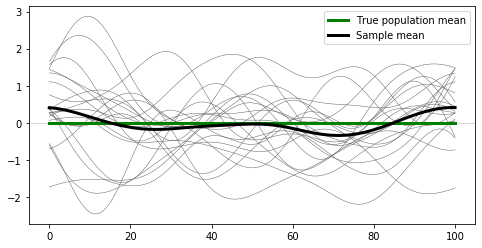

In [1]:
from math import log
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from spm1d import rft1d
eps  = np.finfo(np.float).eps

np.random.seed(100)
J    = 20           # sample size
Q    = 101          # number of continuum nodes
fwhm = 20           # smoothness (full-width-at-half-maximum)
mu   = np.zeros(Q)  # true population mean (the null continuum)
y    = mu + rft1d.randn1d(J, Q, fwhm)


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.axhline(0, color='0.7', lw=0.5)
ax.plot( y.T, '0.4', lw=0.5 )
ax.plot( mu, color='g', lw=3, label='True population mean')
ax.plot( y.mean(axis=0), 'k', lw=3, label='Sample mean' )
ax.legend()
plt.show()

The 1D CI can be constructed nearly identically to the 0D case in Appendix A. The only difference is the critical t value, which needs to be raised to account for the additional points over which the CI is estimated. **rft1d** (one-dimensional random field theory) provides a convenient solution for this revised critical t statistic. The solution requires just one extra parameter: the smoothness parameter (FHMW) that was used to generate the random 1D data above.



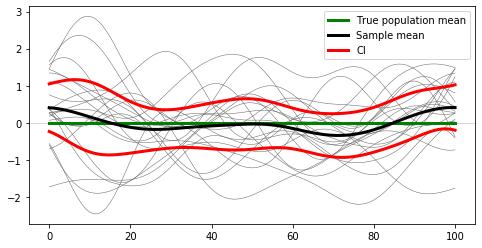

In [2]:

def confidence_interval_1d(y, alpha=0.05):
    '''
    Compute confidence interval for univariate 1D data
    Use known population smoothness "fwhm".
    '''
    J,Q  = y.shape                           # sample size and number of continuum nodes
    ybar = y.mean(axis=0)                    # 1D sample mean
    s    = y.std(axis=0, ddof=1)             # 1D sample standard deviation
    df   = J - 1                             # degrees of freedom
    c    = rft1d.t.isf(alpha/2, df, Q, fwhm) # critical test statistic
    w    = c * s / J**0.5                    # 1D interval width
    ci   = ybar-w, ybar+w                    # 1D confidence interval
    return np.vstack(ci)

ci = confidence_interval_1d(y)


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ybar    = y.mean(axis=0)
ax.axhline(0, color='0.7', lw=0.5)
ax.plot( y.T, '0.4', lw=0.5 )
h0      = ax.plot( mu, color='g', lw=3)[0]
h1      = ax.plot( ybar , 'k', lw=3 )[0]
h2      = ax.plot( ci.T, 'r', lw=3 )[0]
ax.legend([h0,h1,h2], ['True population mean', 'Sample mean', 'CI'])
plt.show()

Note the the true population mean (the null 1D continuum, which contains all zeros) is contained within the CI at all points in the 1D continuum. If the CI did not contain 0, at any of the Q points, the null hypothesis would be rejected.

The `confidence_interval_1d` function above uses the known FWHM is used (i.e., the FWHM value that was used to generate the random data). However, like the population mean and standard deviation, the population FWHM does not have to be known beforehand. It can be instead estimated as demonstrated below. The `estimate_fwhm` code is copied from the **spm1d** package (`spm1d.rft1d.geom.estimate_fwhm`).

In [3]:
def estimate_fwhm(R):
    '''
    Estimate field smoothness (FWHM) from a set of random fields or a set of residuals.
    
    Reference:
    
    Kiebel et al. (1999). Robust smoothness estimation in statistical parametric maps
    using standardized residuals from the general linear model. NeuroImage 10, 756–766.
    '''
    # sum of squared residuals at each continuum point
    ssq    = (R**2).sum(axis=0)
    # gradient estimation
    dy,dx  = np.gradient(R)
    v      = (dx**2).sum(axis=0)
    # normalize:
    v     /= (ssq + eps)
    # ignore zero-variance nodes:
    i      = np.isnan(v)
    v      = v[np.logical_not(i)]
    # global FWHM estimate:
    reselsPerNode = np.sqrt(v / (4*log(2)))
    fwhm   = 1 / reselsPerNode.mean()
    return fwhm


residuals = y - y.mean(axis=0)
efwhm     = estimate_fwhm( residuals )
print('True population FWHM: %.3f' %fwhm)
print('Estimated FWHM: %.3f' %efwhm)



True population FWHM: 20.000
Estimated FWHM: 17.938


Note that the estimated FWHM is not identical to the true population FWHM. This is analogous to the sample mean, illustrated in the figure above, which is not identical to the true population mean. Nevertheless, both are unbiased estimators of the true population parameters.

Let's incorporate this FWHM estimation into the CI calculation, then recalculate the CI for this dataset:

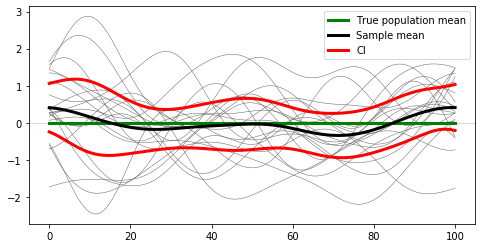

In [4]:
def confidence_interval_1d(y, alpha=0.05):
    '''
    Compute confidence interval for univariate 1D data.
    Use sample smoothness (i.e., estimated population smoothness), calculated from the data "y".
    '''
    J,Q   = y.shape                            # sample size and number of continuum nodes
    ybar  = y.mean(axis=0)                     # 1D sample mean
    s     = y.std(axis=0, ddof=1)              # 1D sample standard deviation
    df    = J - 1                              # degrees of freedom
    efwhm = estimate_fwhm(y-ybar)              # estimated smoothness
    c     = rft1d.t.isf(alpha/2, df, Q, efwhm) # critical test statistic
    w     = c * s / J**0.5                     # 1D interval width
    ci    = ybar-w, ybar+w                     # 1D confidence interval
    return np.vstack(ci)


ci = confidence_interval_1d(y)


fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ybar    = y.mean(axis=0)
ax.axhline(0, color='0.7', lw=0.5)
ax.plot( y.T, '0.4', lw=0.5 )
h0      = ax.plot( mu, color='g', lw=3)[0]
h1      = ax.plot( ybar , 'k', lw=3 )[0]
h2      = ax.plot( ci.T, 'r', lw=3 )[0]
ax.legend([h0,h1,h2], ['True population mean', 'Sample mean', 'CI'])
plt.show()

Notice that the FWHM estimation errors have little qualitative effect on the CI, which still contains the true population mean at all Q points.

___

### 1D Prediction intervals (PIs)

Similar to above, the 0D PI from Appendix A requires only minor adjustments in order to make it suitable for 1D data. These adjustments are: (1) FWHM estimation, and (2) critical threshold calculation.


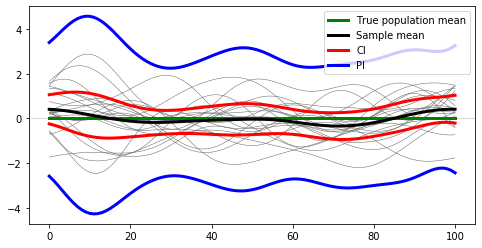

In [5]:
def prediction_interval_1d(y, alpha=0.05):
    '''
    Compute prediction interval for univariate 1D data.
    Use sample smoothness (i.e., estimated population smoothness), calculated from the data "y".
    '''
    J,Q   = y.shape
    ybar  = y.mean(axis=0)                     # sample mean
    s     = y.std(axis=0, ddof=1)              # sample standard deviation
    df    = J - 1                              # degrees of freedom
    efwhm = estimate_fwhm(y-ybar)              # estimated smoothness
    c     = rft1d.t.isf(alpha/2, df, Q, efwhm) # critical test statistic
    w     = c * s * (1+(1/J))**0.5             # interval width
    pi    = ybar-w, ybar+w                     # prediction interval
    return np.array(pi)

pi  = prediction_interval_1d(y)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ybar = y.mean(axis=0)
ax.axhline(0, color='0.7', lw=0.5)
ax.plot( y.T, '0.4', lw=0.5 )
h0   = ax.plot( mu, color='g', lw=3)[0]
h1   = ax.plot( ybar , 'k', lw=3 )[0]
h2   = ax.plot( ci.T, 'r', lw=3 )[0]
h3   = ax.plot( pi.T, 'b', lw=3 )[0]
ax.legend([h0,h1,h2,h3], ['True population mean', 'Sample mean', 'CI', 'PI'])
plt.show()

___

### Numerically validating 1D confidence and prediction intervals

Similar to Appendix A, 1D CIs and PIs can be numerically validated by simulating a large number of datasets, constructing intervals for each experiment, and then checking whether the true mean (CI) or a new observation (PI) lies within the interval.

In [6]:
np.random.seed(1)   # seed the random number generator to replicate results
J           = 10    # sample size
Q           = 101   # number of continuum nodes
fwhm        = 20    # smoothness (full-width-at-half-maximum)
niterations = 200   # number of datasets / experiments to simulate
in_ci       = []    # list that will hold one True or False value for each iteration
in_pi       = []    # list that will hold one True or False value for each iteration
mu          = np.zeros(Q) # true population mean
alpha       = 0.05  # Type I error rate

for i in range(niterations):
    y       = mu + rft1d.randn1d(J, Q, fwhm) # Gaussian data
    
    # confidence interval
    ci      = confidence_interval_1d(y, alpha)
    b       = np.logical_and( mu>=ci[0], mu<=ci[1] )
    in_ci.append( np.all( b ) )
    
    # prediction interval
    pi      = prediction_interval_1d(y, alpha)
    yy      = mu + rft1d.randn1d(1, Q, fwhm) # Gaussian data
    b       = np.logical_and( yy>=pi[0], yy<=pi[1] )
    in_pi.append( np.all( b ) )

    
prop_in  = np.mean( in_ci ) # proportion of experiments where the true mean lies inside the CI 
prop_out = 1 - prop_in      # proportion of experiments where the true mean lies outside the CI 

print('Proportion of random datasets with mu inside CI: %.3f' %prop_in)
print('Proportion of random datasets with mu outside CI: %.3f' %prop_out)

prop_in  = np.mean( in_pi ) # proportion of experiments where the true mean lies inside the CI 
prop_out = 1 - prop_in      # proportion of experiments where the true mean lies outside the CI 

print()
print('Proportion of random datasets with new observations inside PI: %.3f' %prop_in)
print('Proportion of random datasets with new observations PI: %.3f' %prop_out)

Proportion of random datasets with mu inside CI: 0.970
Proportion of random datasets with mu outside CI: 0.030

Proportion of random datasets with new observations inside PI: 0.960
Proportion of random datasets with new observations PI: 0.040


___

### Summary

This Appendix demonstrated calculation and numerical validation of CIs and PIs for 1D data. Identical to Appendix A, the key points are:

* A false positive occurs for a CI when the true population mean lies outside the CI
* A false positive occurs for a PI when a new, random observation lies outside the PI

and

* 95% CIs contain the true population mean with a probability of 0.95
* 95% PIs contain a new, random observation with a probability of 0.95
* 95% CIs and PIs both have false positive rates of $\alpha$=0.05

The only difference between this Appendix and Appendix A is that a random field theory (RFT) correction was used to correct for multiple comparisons across the Q continuum nodes. This RFT correction is based on the estimated smoothness over the 1D domain.